In [1]:
# data manipulation:
import pandas as pd
import numpy as np

# stats:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from scipy import stats
import math

# plotting and images:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

---
## About the data:

In this chapter we look at one of the recession indicators - the Housing/Rent ratio.

The ratio is calculated using the housing price and rent price indices as collected by the Federal Reserve Bank of St. Louis. 

Using process control charts (as developed by Walter Shewhart of Bell Labs in the 1920's), we analyze the normalized ratios and use the criteria outlined by Shewhart to determine whether the "process" is undergoing significant change. 

As we will see, Shewhart process control charts do a great job of indicatin incoming recessions.


***What Is the House Price Index (HPI)?***
The House Price Index (HPI) is a broad measure of the movement of single-family property prices in the United States. Aside from serving as an indicator of house price trends, it also functions as an analytical tool for estimating changes in the rates of mortgage defaults, prepayments, and housing affordability.

The HPI is pieced together by the Federal Housing Finance Agency (FHFA), using data supplied by the Federal National Mortgage Association (FNMA), typically known as Fannie Mae, and the Federal Home Loan Mortgage Corp. (FHLMC), commonly known as Freddie Mac.

The HPI is based on transactions involving conventional and conforming mortgages on single-family properties. It is a weighted repeat sales index, measuring average price changes in repeat sales or refinancings on the same properties.


Sources: 
https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index.aspx


Housing Index: https://fred.stlouisfed.org/series/CSUSHPINSA

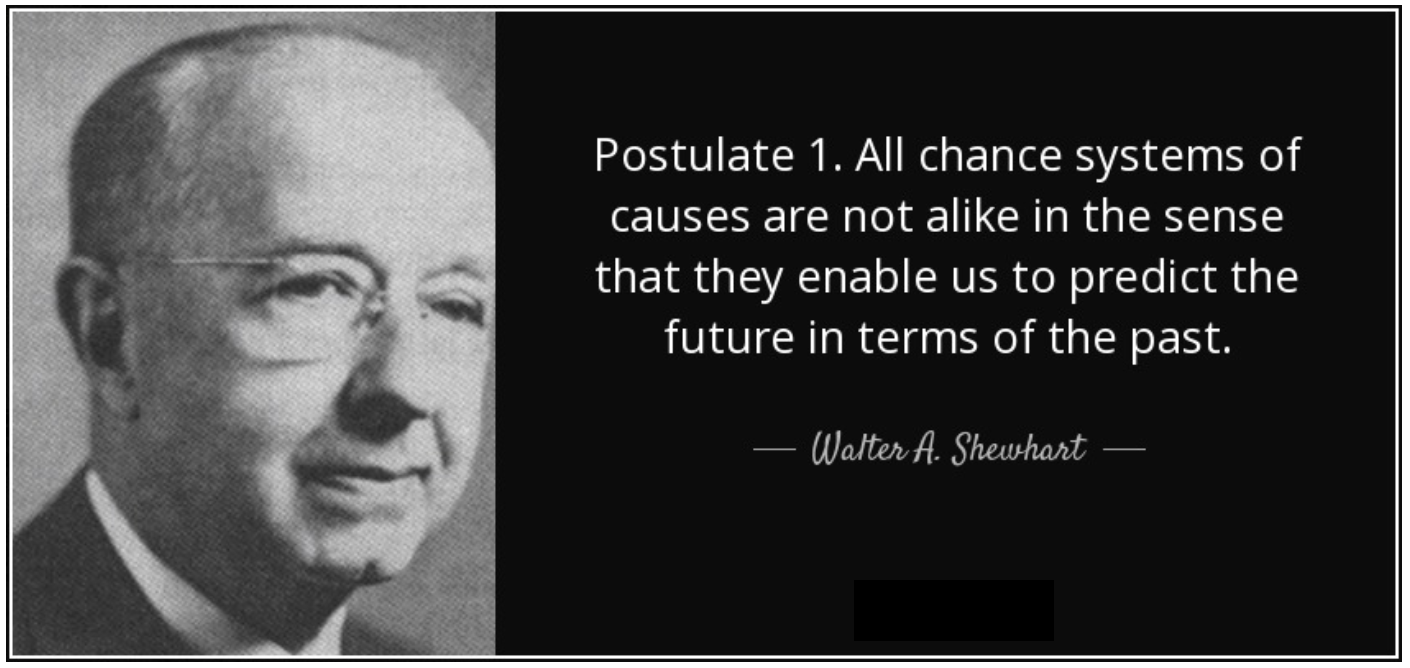

In [2]:
Image(filename='./images/quote.png', width=800)

---

### Import the dataset:

In [3]:
housing_df = pd.read_excel('HousingNew.xlsx', header=10).iloc[0:391, 0:3]
housing_df.rename(columns={'CSUSHPINSA': 'Housing Index', 'Rent': 'Rent Index'}, inplace=True)
housing_df

,observation_date,Housing Index,Rent Index
0,1987-01-01,63.755,121.300
1,1987-02-01,64.155,121.700
2,1987-03-01,64.490,121.800
3,1987-04-01,64.995,122.000
4,1987-05-01,65.569,122.300
...,...,...,...
386,2019-03-01,206.088,327.513
387,2019-04-01,207.998,328.678
388,2019-05-01,209.690,329.333
389,2019-06-01,210.898,330.648


---

### Calculate the ratio in housing to rent index and keep track of the change over time:

In [4]:
# ratio of housing to rent index:
housing_df['Housing/Rent'] = housing_df['Housing Index'] / housing_df['Rent Index']

# shift the ratio to allow for easy calculation of the difference:
housing_df['Change %'] = housing_df['Housing/Rent'] - housing_df['Housing/Rent'].shift(1)
housing_df

,observation_date,Housing Index,Rent Index,Housing/Rent,Change %
0,1987-01-01,63.755,121.300,0.525598,NaN
1,1987-02-01,64.155,121.700,0.527157,0.001559
2,1987-03-01,64.490,121.800,0.529475,0.002318
3,1987-04-01,64.995,122.000,0.532746,0.003271
4,1987-05-01,65.569,122.300,0.536132,0.003387
...,...,...,...,...,...
386,2019-03-01,206.088,327.513,0.629251,0.001893
387,2019-04-01,207.998,328.678,0.632832,0.003581
388,2019-05-01,209.690,329.333,0.636711,0.003879
389,2019-06-01,210.898,330.648,0.637832,0.001121


---
### Plot Indices and change over time:

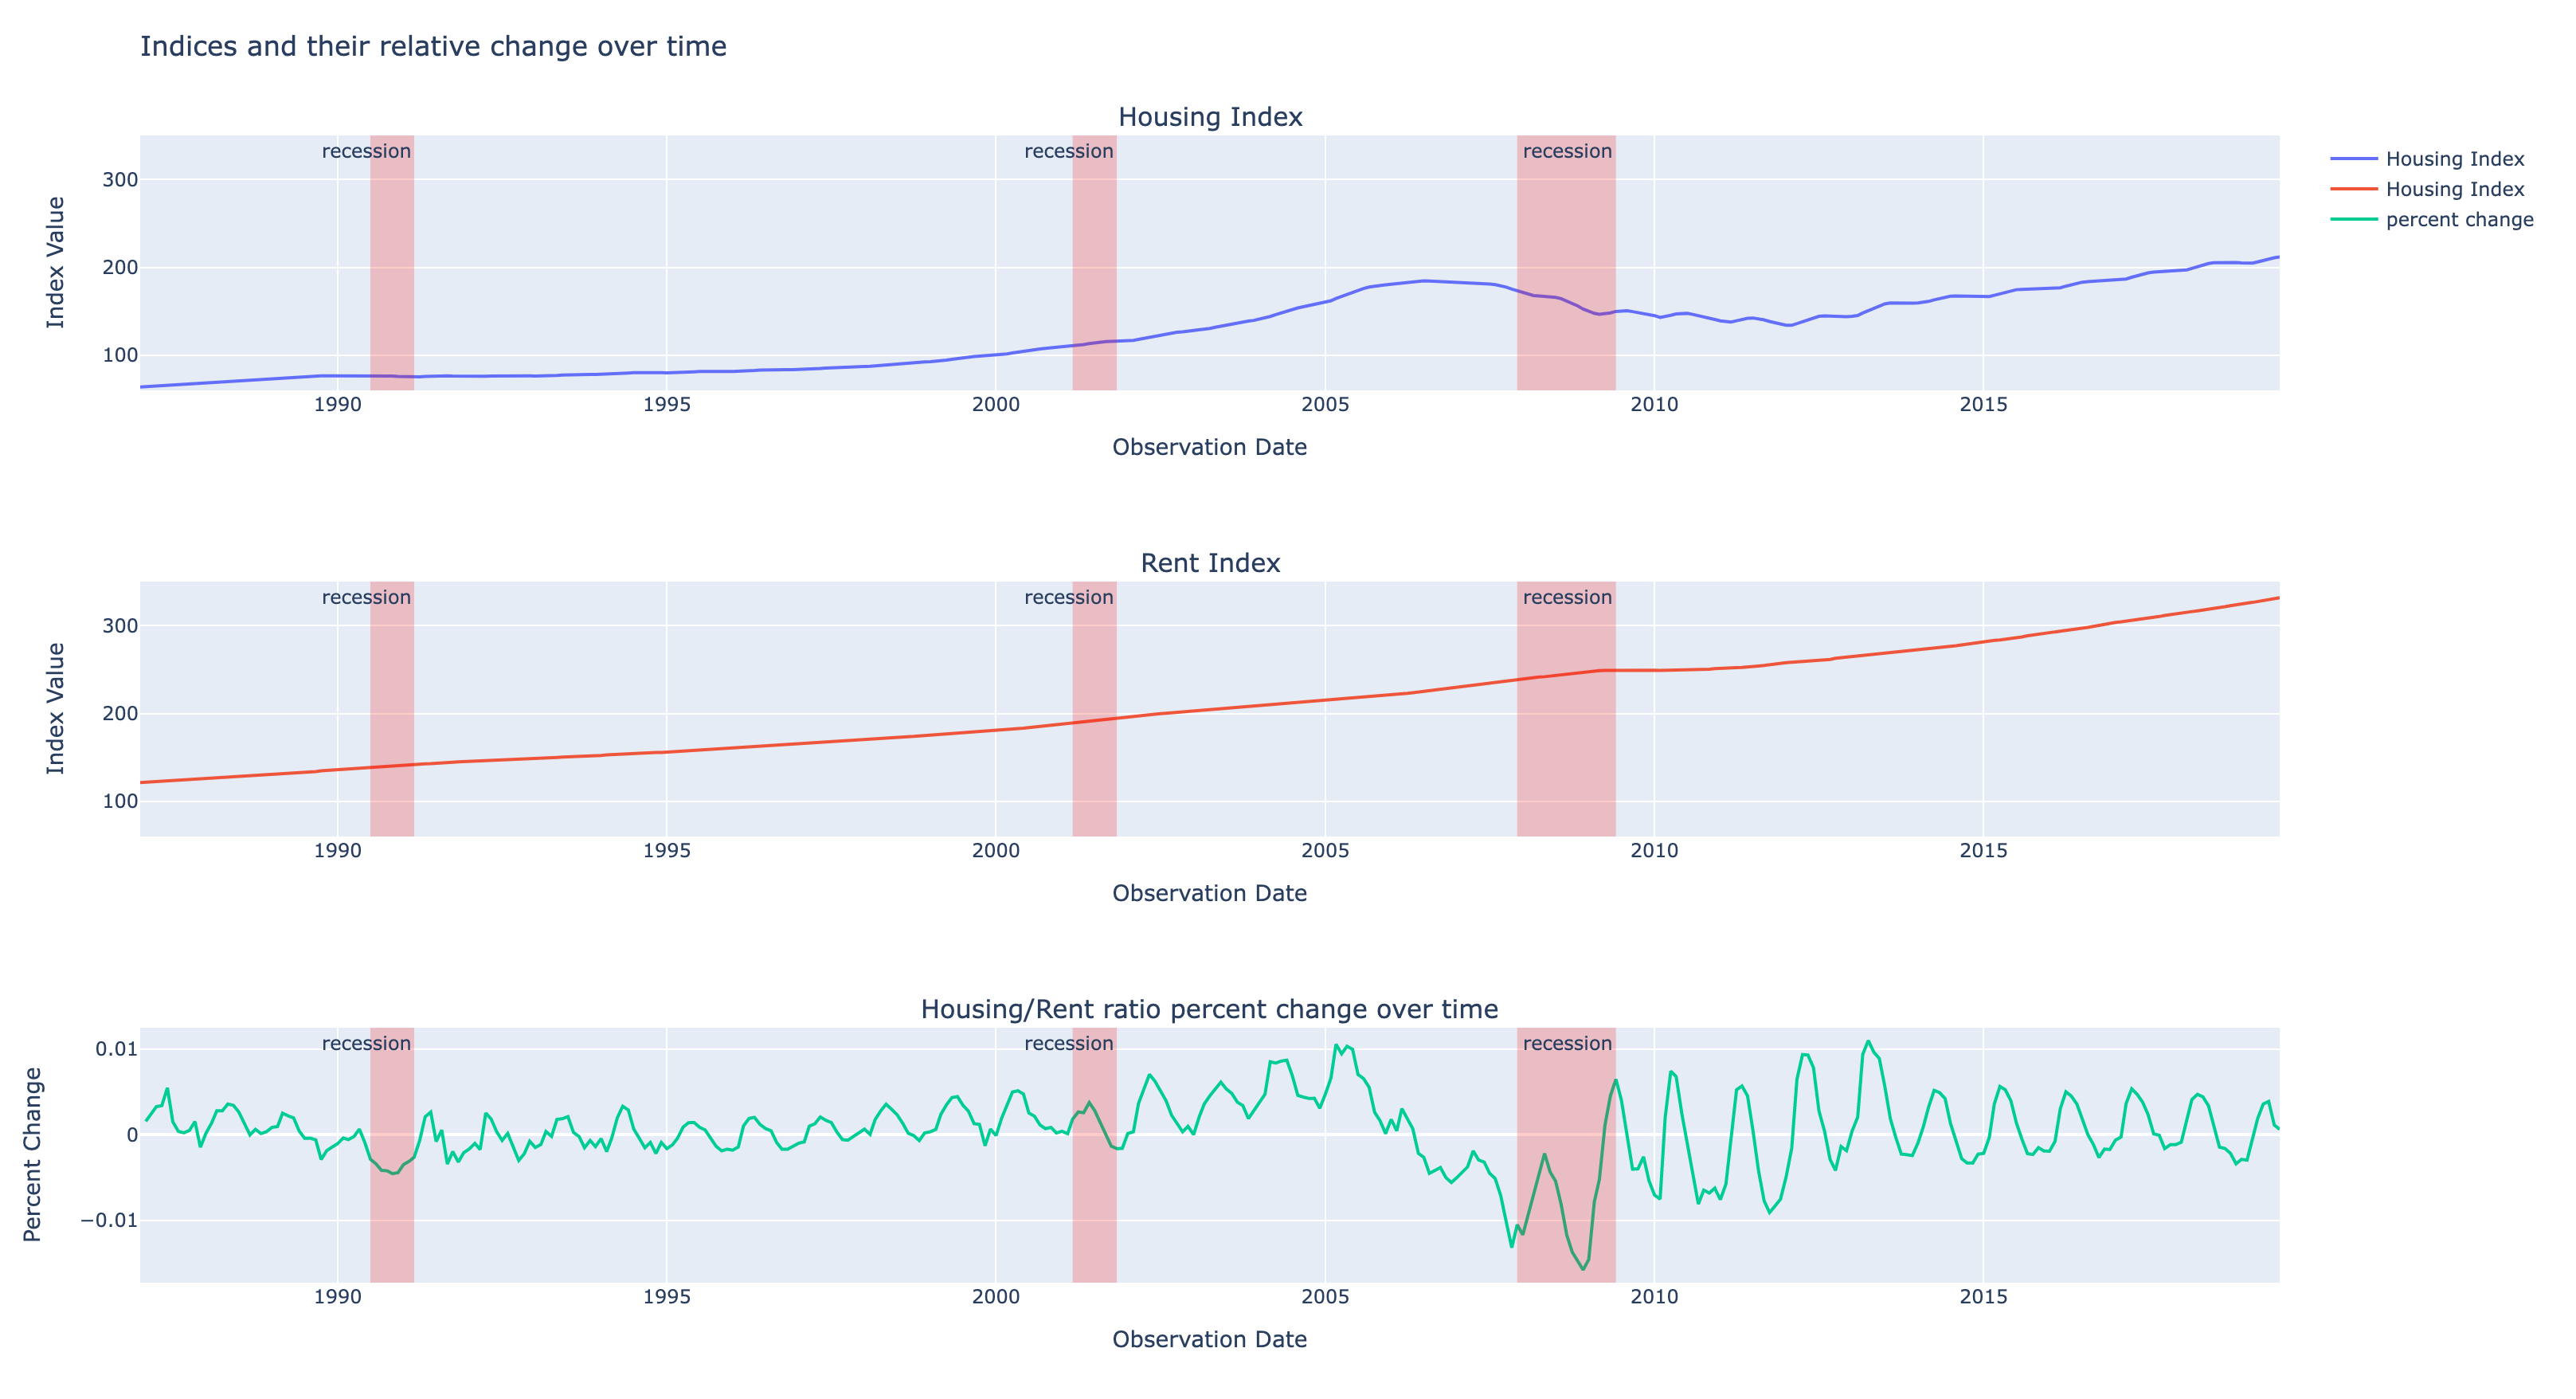

In [5]:
# set subplot fig object:
fig = make_subplots(rows=3, cols=1, subplot_titles=("Housing Index", "Rent Index", "Housing/Rent ratio percent change over time"))

# set housing idex figure object:
housing_fig = go.Scatter(x=housing_df['observation_date'], y=housing_df['Housing Index'], name='Housing Index')

# set rent idex figure object:
rent_fig = go.Scatter(x=housing_df['observation_date'], y=housing_df['Rent Index'], name='Housing Index')

# set percent change figure object:
change_fig = go.Scatter(x=housing_df['observation_date'], y=housing_df['Change %'], name='percent change')

# append traces to subplot fig and build it:
fig.append_trace(housing_fig, row=1, col=1)
fig.append_trace(rent_fig, row=2, col=1)
fig.append_trace(change_fig, row=3, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Observation Date", row=1, col=1)
fig.update_xaxes(title_text="Observation Date", row=2, col=1)
fig.update_xaxes(title_text="Observation Date", row=3, col=1)


# Update yaxis properties
fig.update_yaxes(title_text="Index Value", range=[60, 350], row=1, col=1)
fig.update_yaxes(title_text="Index Value", range=[60, 350], row=2, col=1)
fig.update_yaxes(title_text="Percent Change", row=3, col=1)

# show periods of recession:
fig.add_vrect(x0='2007-12-01', x1='2009-06-01', line_width=0, fillcolor="red", opacity=0.2, annotation_text="recession")
fig.add_vrect(x0='2001-03-01', x1='2001-11-01', line_width=0, fillcolor="red", opacity=0.2, annotation_text="recession")
fig.add_vrect(x0='1990-07-01', x1='1991-03-01', line_width=0, fillcolor="red", opacity=0.2, annotation_text="recession")

# layout:
fig.update_layout(
        height=900,
        width=1600,
        title_text='Indices and their relative change over time'
    )

fig
Image(filename='./images/indices.png', width=1600)

##### Source for recession dates and duration: https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States


**Note:** Pay special attention to the "Housing/Rent ratio percent over time" plot. The behavior displayed in this graph  will be a key tool in helping us determine whether the "process" is out of control. 

In short, if the housing prices were stable relative to the rent prices, then the ratio should remain unchanged. Whereas if the housing prices were increasing faster than rents, then the change would be positive. In contrast, if the housing prices were increasing at a rate slower than rents, the change would be negative.

In short:

#### POSITIVE change: housing prices are rising at a faster rate in comparison to rents (bubble inflates)
#### NEGATIVE chnage: rent prices are rising at a faster rate in comparison to housing prices (bubble deflates)

---


### Check correlation (strength of relationship) between Housing and Rent Indices:

In [6]:
# calculate the Pearson correlation directly:
from scipy.stats import pearsonr
corr, _ = pearsonr(housing_df['Housing Index'], housing_df['Rent Index'])
print(corr)

0.9343962500703271


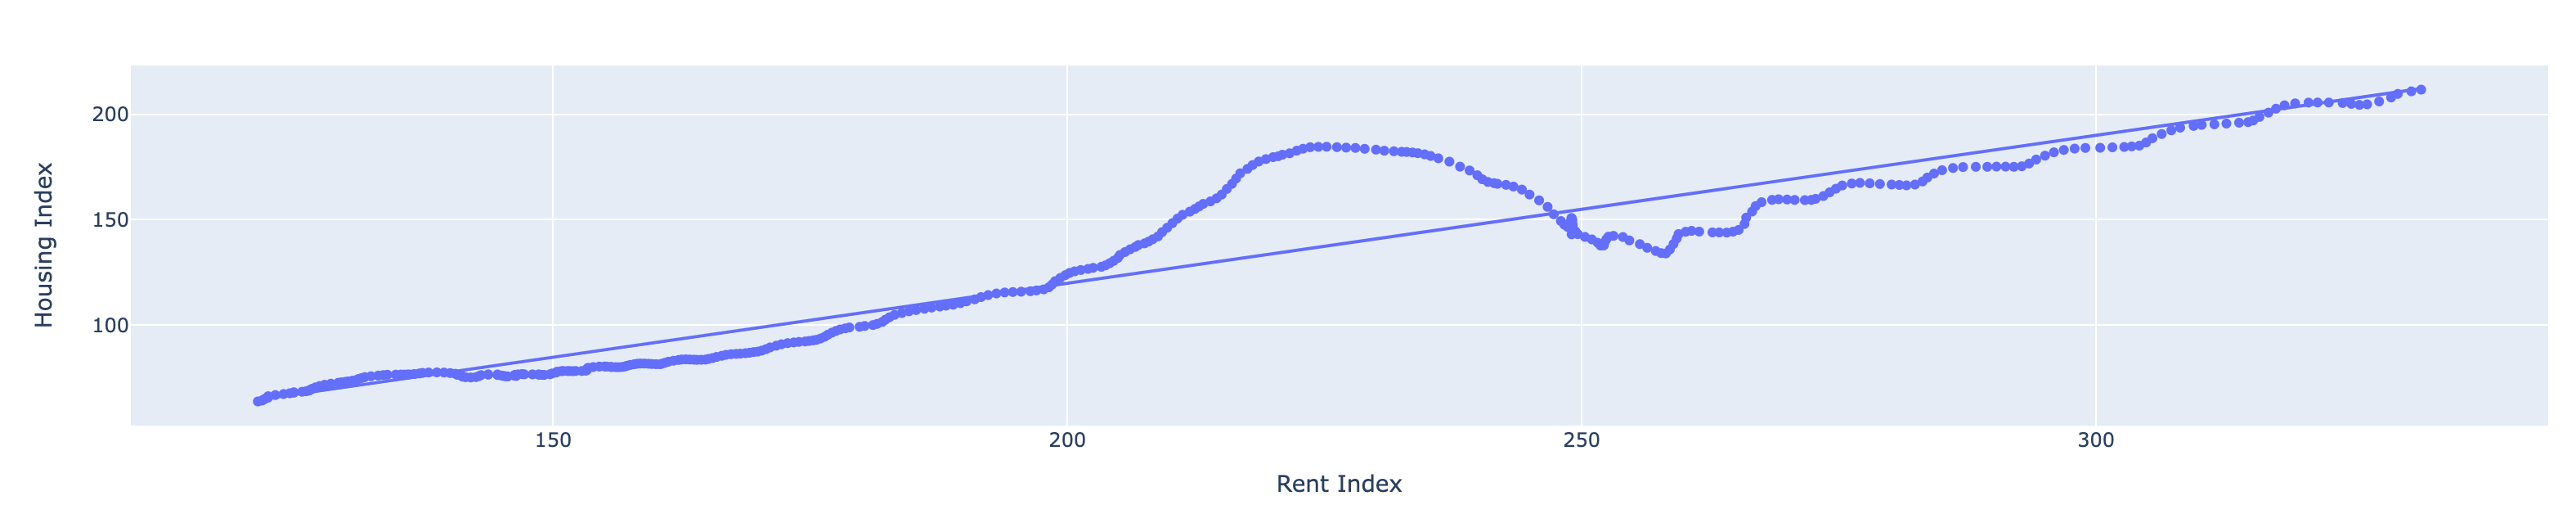

In [7]:
# fit a trendline and take the square root of the R-squared value:
corr_fig = px.scatter(housing_df, x='Rent Index', y='Housing Index', trendline='ols')
corr_fig
Image(filename='./images/trendline.png', width=1500)

In [8]:
# extract R-squared value from trendline and take square root (to get correlation):
r_sqrd = px.get_trendline_results(corr_fig).px_fit_results.iloc[0].rsquared
print(f"R-squared = {r_sqrd}, correlation = {np.sqrt(r_sqrd)}")

R-squared = 0.8730963521454893, correlation = 0.9343962500703271


**Note:** As we can see from the results above (correlation coefficient $= 0.93$), the housing and rent indices are very strongly correlated with approximately $87\%$ of the variation explained by the dependent variable.

---
#### Plot % change distribution:

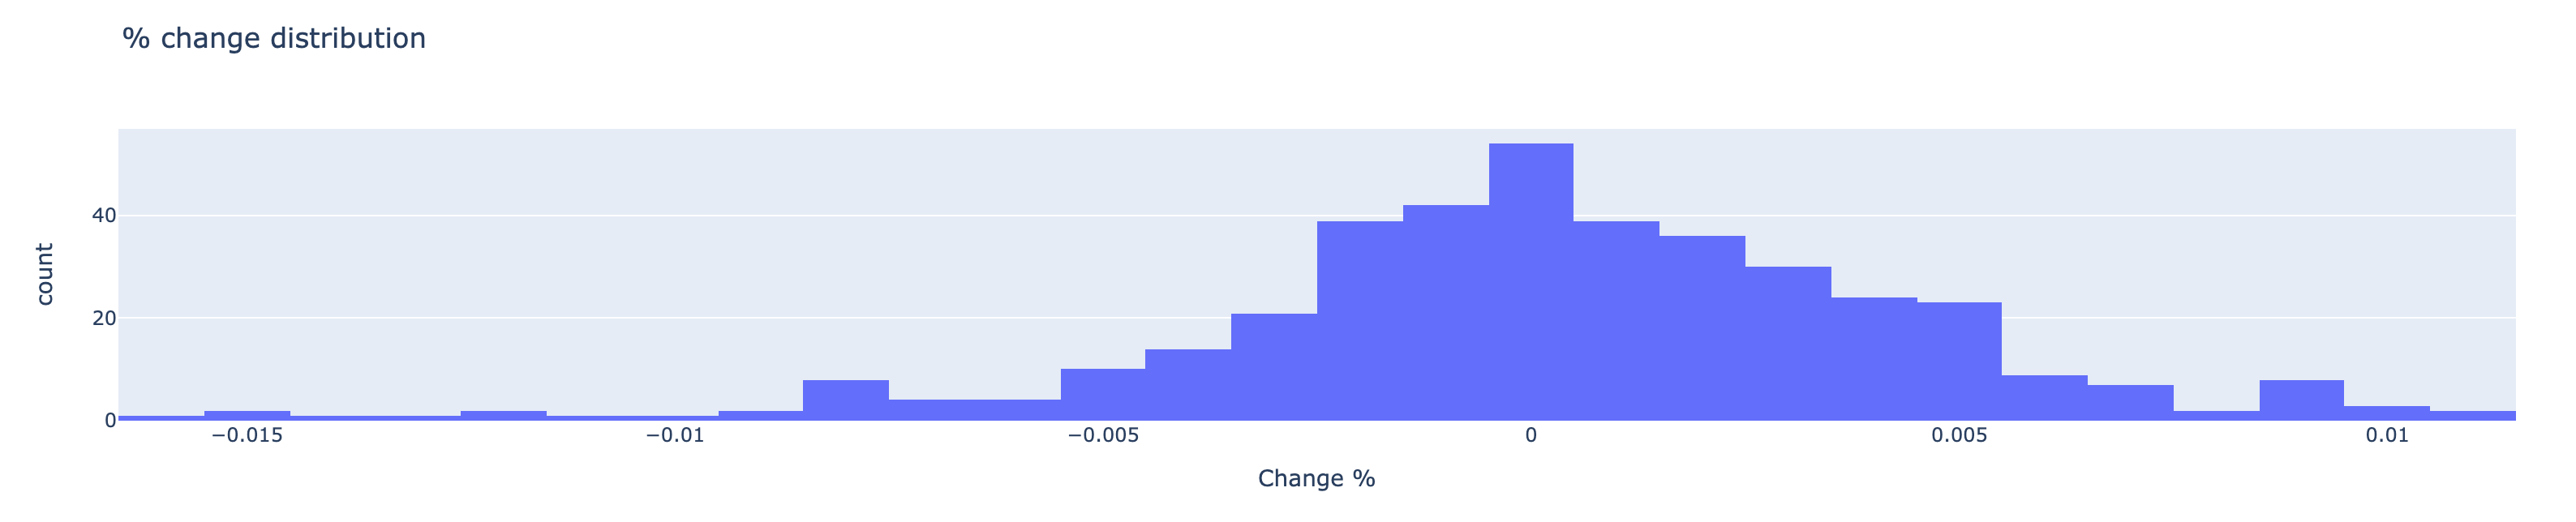

In [9]:
# plot the change histogram:
px.histogram(housing_df, "Change %", title='% change distribution')
Image(filename='./images/change_dist.png', width=1600)

As we can see from the plot above, the distribution is approximately normal, with a negative skew. This means that we have more extreme values on the negative side of our x-axis, which in this case correspond to rent prices rising faster and out-of-step with housing prices.

The shape above meets the requirements for applying the "Shewhart Process Control Test" to the housing data.

---
### Examine the "Shewhart Process" to determine whether the "process" is out of control (or not):
Please remember that the "process" in question is the relationship between **housing prices and rent prices.** As we have shown in the histogram above and preceding charts, in healthy economy these will track each other more or less closely.

Below we define the zones as given in the text. We will use these later to label zones in the different plots and show the trends as the process is changing state.

In [10]:
zones_df = pd.DataFrame({'Zone': ['Upper Zone A', 'Lower Zone A', 'Upper Zone B', 'Lower Zone B', 'Upper Zone C', 'Lower Zone C'], 
                        'Criteria': ['between (mean + 2 std) & (mean + 3 std)', 'between (mean - 3 std) & (mean - 2 std)', 'between (mean + 1 std) & (mean + 2 std)',
                                    'between (mean - 2 std) & (mean - 1 std)', 'between (mean) & (mean + 1 std)', 'between (mean - 1std) & (mean)']})
zones_df

,Zone,Criteria
0,Upper Zone A,between (mean + 2 std) & (mean + 3 std)
1,Lower Zone A,between (mean - 3 std) & (mean - 2 std)
2,Upper Zone B,between (mean + 1 std) & (mean + 2 std)
3,Lower Zone B,between (mean - 2 std) & (mean - 1 std)
4,Upper Zone C,between (mean) & (mean + 1 std)
5,Lower Zone C,between (mean - 1std) & (mean)


#### Criteria:

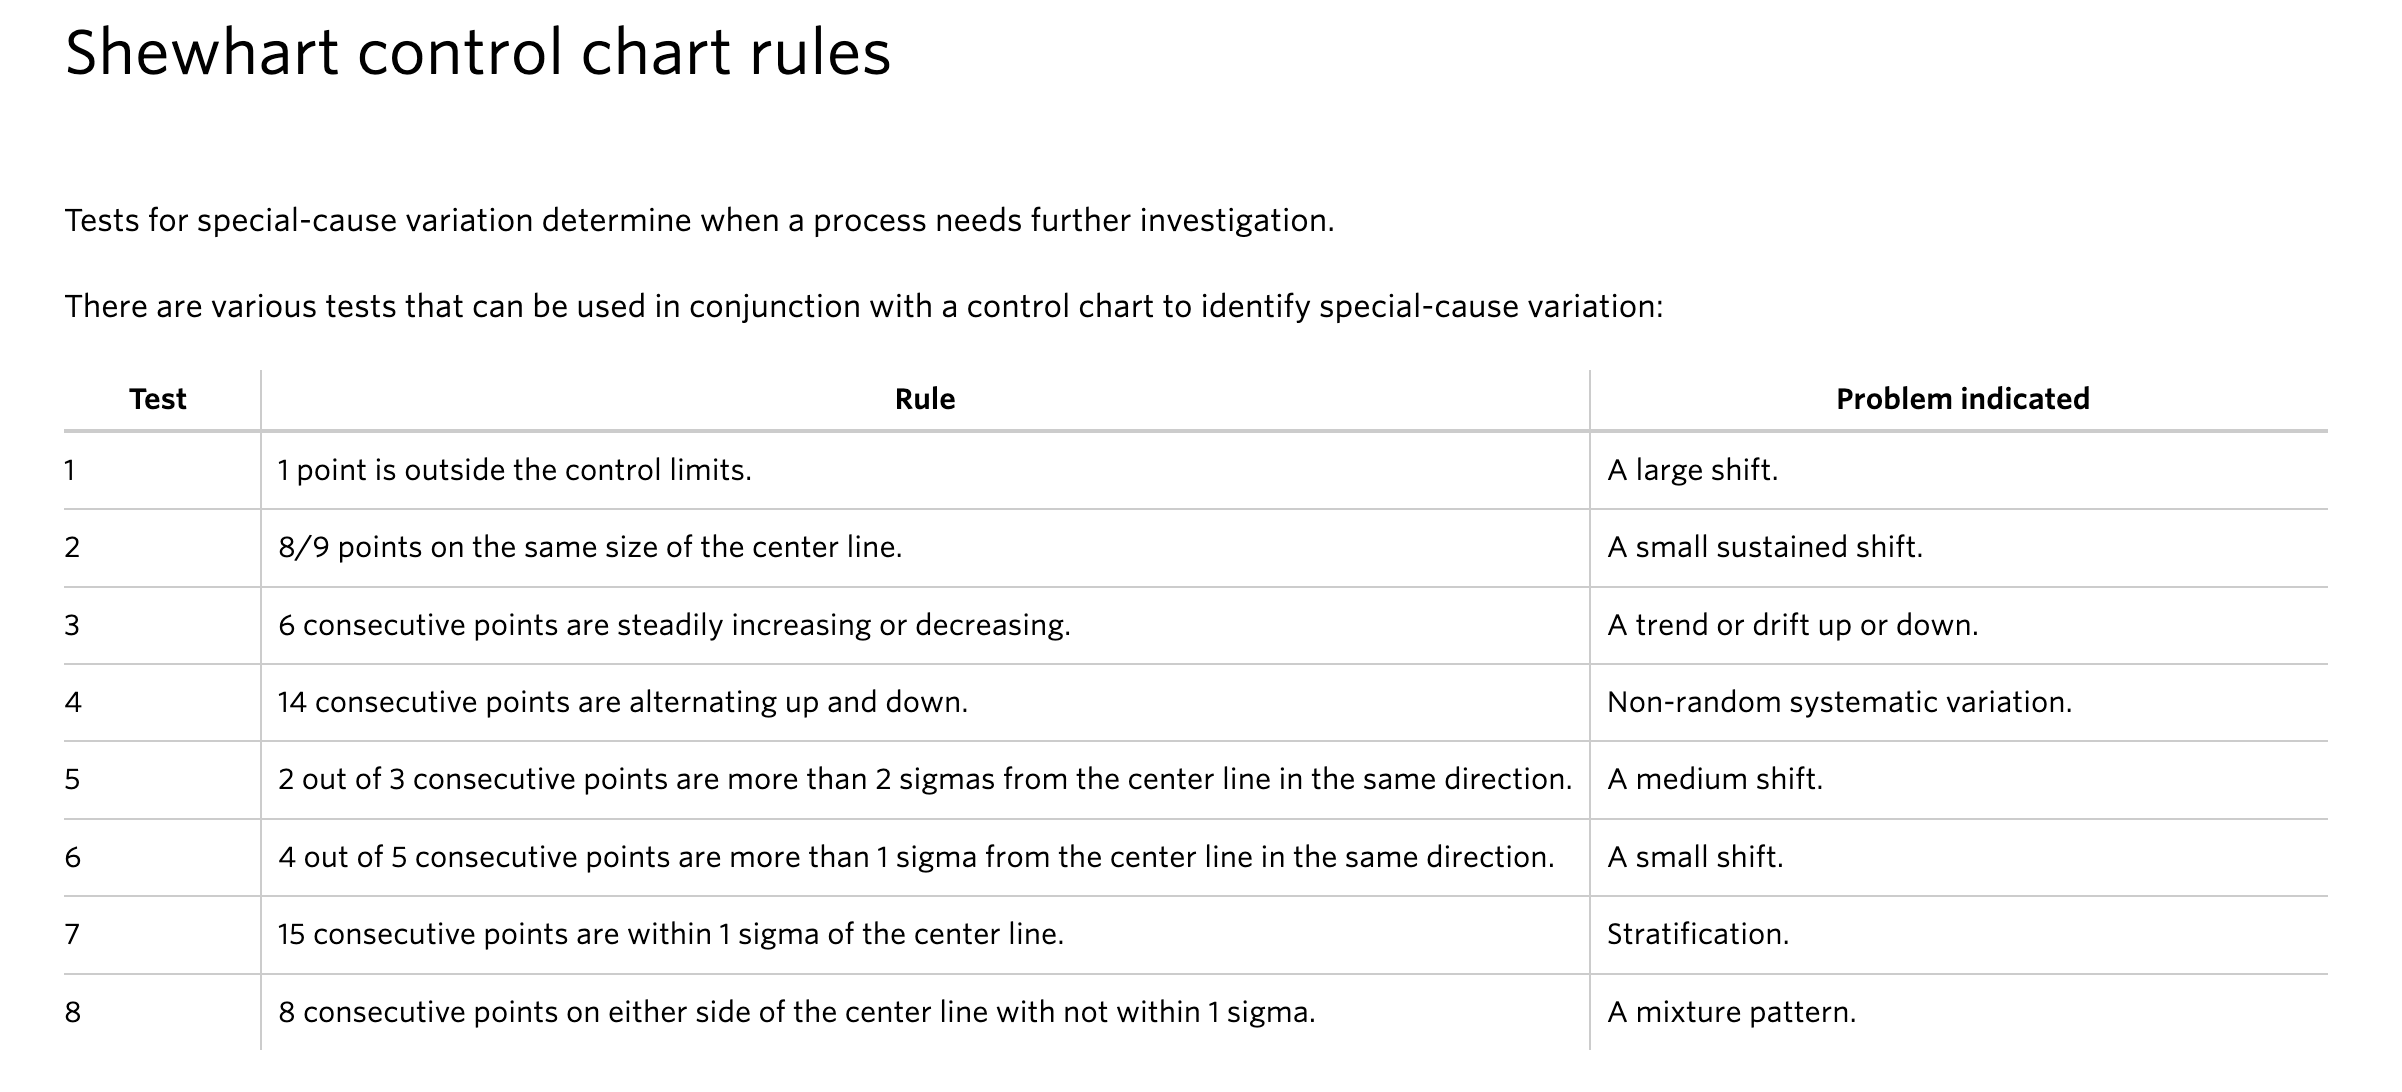

In [11]:
Image(filename='./images/shewhart_rules.png', width=1000)

---
#### Calculate metrics to track process change: rolling means, stds, and z-scores:
Below we use a two-year window to begin the rolling calculations (24 months). We aggregate every period thereafter (i.e. the means and stds are computed on all prior months). 

In [12]:
# calculate rolling mean, std, and z-score with a two-year (24 month) lag:
housing_df['rolling_mean'] = housing_df['Change %'].expanding(min_periods=24).mean()
housing_df['rolling_std'] = housing_df['Change %'].expanding(min_periods=24).std()

# z-scores:
housing_df['rolling_zscore'] = (housing_df['Change %'] - housing_df['rolling_mean']) / (housing_df['rolling_std'])

# define trend as positive or negative:
housing_df['trend'] = housing_df['rolling_zscore'].apply(lambda x: 'Above Centerline' if x >= 0 else 'Below Centerline' if x < 0 else 'undefined')
housing_df.iloc[23:,:]

,observation_date,Housing Index,Rent Index,Housing/Rent,Change %,rolling_mean,rolling_std,rolling_zscore,trend
23,1988-12-01,73.288,130.100,0.563321,0.000339,NaN,NaN,NaN,undefined
24,1989-01-01,73.624,130.500,0.564169,0.000848,0.001607,0.001572,-0.482813,Below Centerline
25,1989-02-01,73.974,130.900,0.565118,0.000950,0.001581,0.001545,-0.408503,Below Centerline
26,1989-03-01,74.416,131.100,0.567628,0.002509,0.001617,0.001524,0.585692,Above Centerline
27,1989-04-01,74.874,131.400,0.569817,0.002190,0.001638,0.001499,0.368167,Above Centerline
...,...,...,...,...,...,...,...,...,...
386,2019-03-01,206.088,327.513,0.629251,0.001893,0.000269,0.004169,0.389661,Above Centerline
387,2019-04-01,207.998,328.678,0.632832,0.003581,0.000277,0.004167,0.792793,Above Centerline
388,2019-05-01,209.690,329.333,0.636711,0.003879,0.000286,0.004166,0.862424,Above Centerline
389,2019-06-01,210.898,330.648,0.637832,0.001121,0.000289,0.004161,0.200135,Above Centerline


---
#### Visualize "mass" of events in each zone:

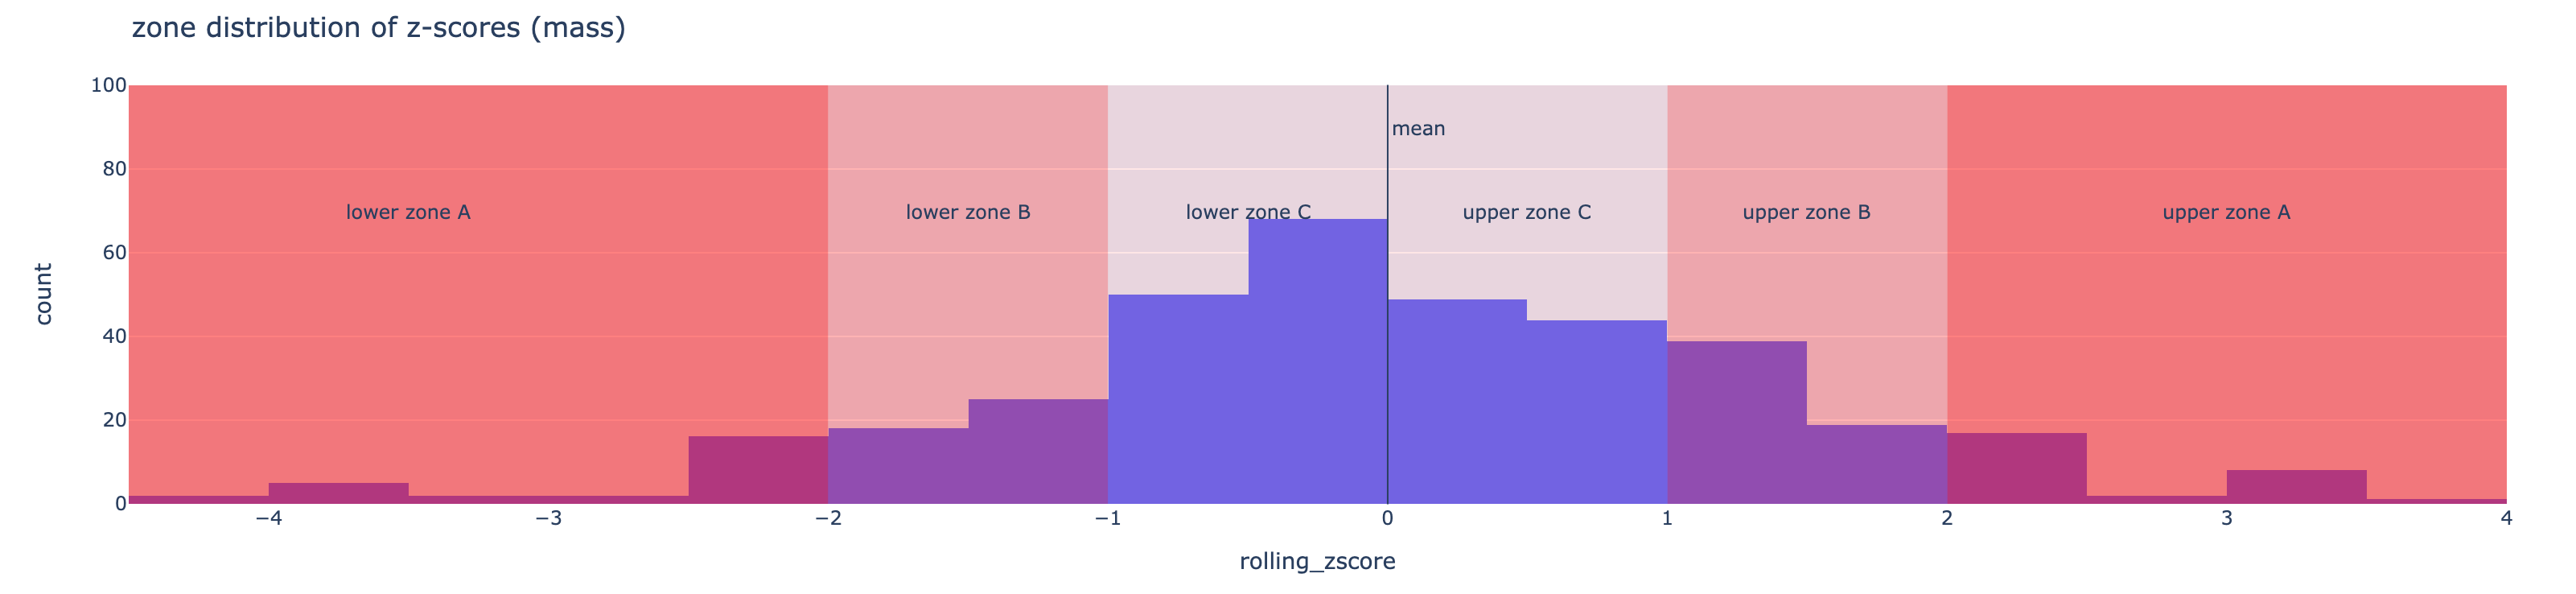

In [13]:
# plot distribution of z-values to visualize the "mass" in each zone: 
shewhart_fig = px.histogram(housing_df, x='rolling_zscore')

# zones:
shewhart_fig.add_vrect(x0='-2', x1='-4.5', line_width=0, fillcolor="red", opacity=0.5)
shewhart_fig.add_vrect(x0='-1', x1='-2', line_width=0, fillcolor="red", opacity=0.3)
shewhart_fig.add_vrect(x0='0', x1='-1', line_width=0, fillcolor="red", opacity=0.1)
shewhart_fig.add_vrect(x0='0', x1='1', line_width=0, fillcolor="red", opacity=0.1)
shewhart_fig.add_vrect(x0='1', x1='2', line_width=0, fillcolor="red", opacity=0.3)
shewhart_fig.add_vrect(x0='2', x1='4', line_width=0, fillcolor="red", opacity=0.5)
shewhart_fig.add_vrect(x0='0', x1='0', line_width=1, fillcolor="blue", opacity=1)

# annotations:
shewhart_fig.add_annotation(x=-3.5, y=70, text="lower zone A", showarrow=False)
shewhart_fig.add_annotation(x=-1.5, y=70, text="lower zone B", showarrow=False)
shewhart_fig.add_annotation(x=-0.5, y=70, text="lower zone C", showarrow=False)
shewhart_fig.add_annotation(x=0.5, y=70, text="upper zone C", showarrow=False)
shewhart_fig.add_annotation(x=1.5, y=70, text="upper zone B", showarrow=False)
shewhart_fig.add_annotation(x=3, y=70, text="upper zone A", showarrow=False)
shewhart_fig.add_annotation(x=0.11, y=90, text="mean", showarrow=False)

# update layout:
shewhart_fig.update_layout(title= 'zone distribution of z-scores (mass)', height=400)
shewhart_fig.update_yaxes(range=[0, 100])
Image(filename='./images/mass.png', width=1600)

The plot above shows us how many events fall in each zone. We see that for the most part, the majority of events (in this case months since January of 1987) are in upper and lower zone C, which correspond to healthy levels of change between the housing and rent indices.

---
#### Visualize frequency of events in each zone (over time):

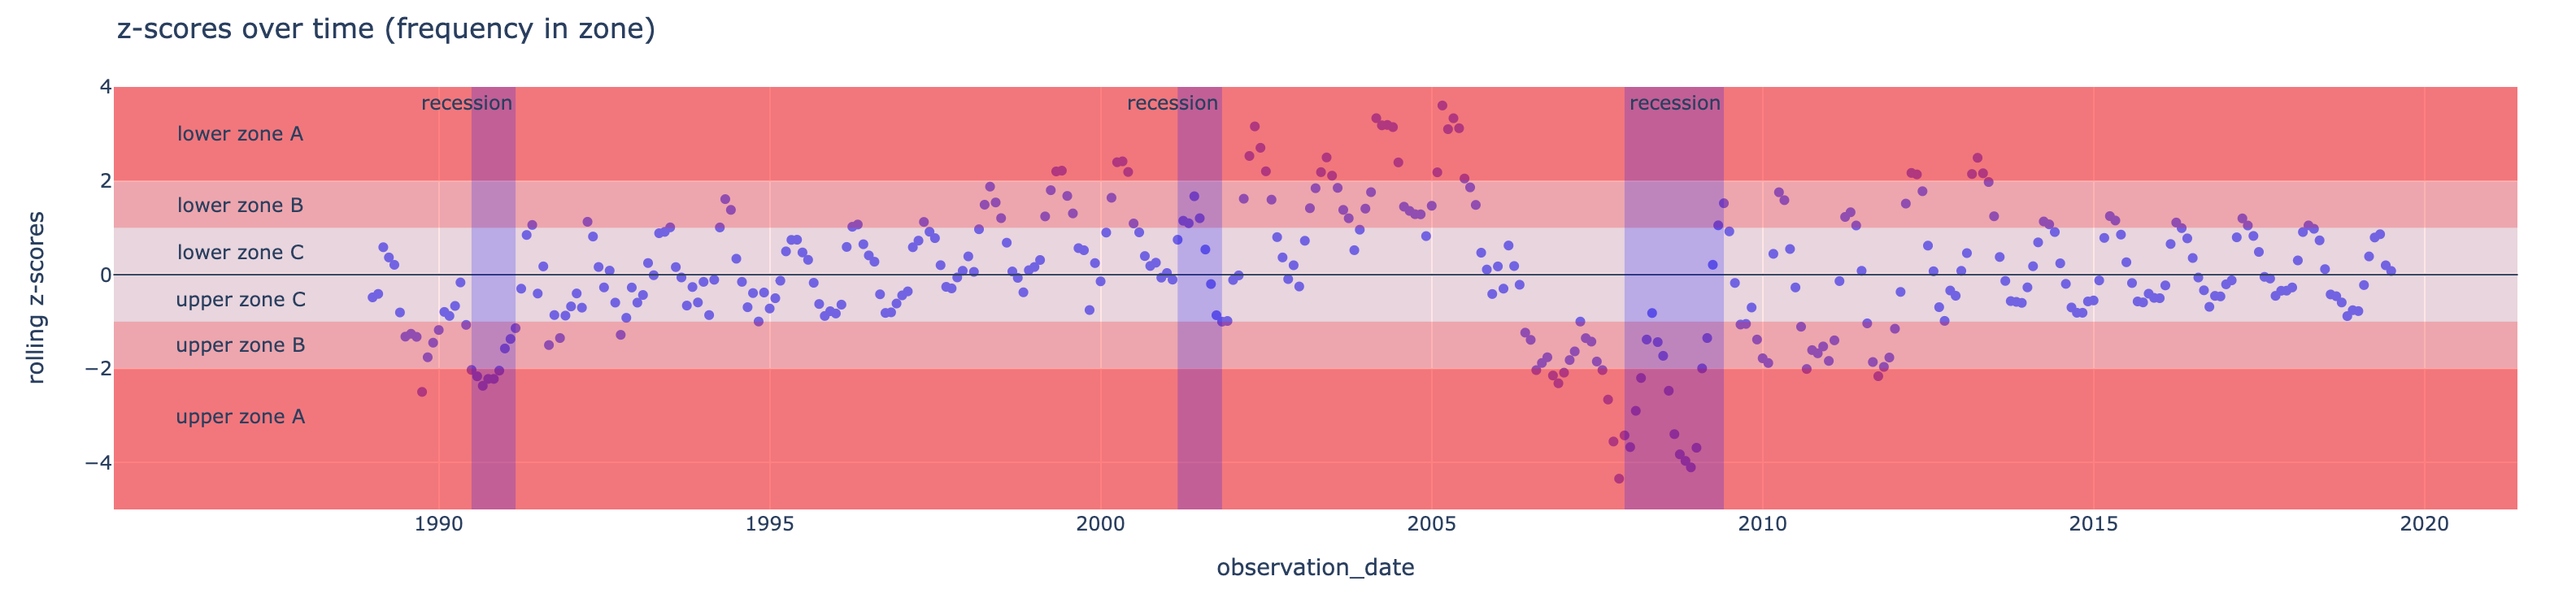

In [14]:
# set scatter figure to track behavior over time.
shewhart_scatter = px.scatter(housing_df, x='observation_date', y='rolling_zscore')

# zones:
shewhart_scatter.add_hrect(y0='-2', y1='-5', line_width=0, fillcolor="red", opacity=0.5)
shewhart_scatter.add_hrect(y0='-1', y1='-2', line_width=0, fillcolor="red", opacity=0.3)
shewhart_scatter.add_hrect(y0='0', y1='-1', line_width=0, fillcolor="red", opacity=0.1)
shewhart_scatter.add_hrect(y0='0', y1='1', line_width=0, fillcolor="red", opacity=0.1)
shewhart_scatter.add_hrect(y0='1', y1='2', line_width=0, fillcolor="red", opacity=0.3)
shewhart_scatter.add_hrect(y0='2', y1='4', line_width=0, fillcolor="red", opacity=0.5)
shewhart_scatter.add_hrect(y0='0', y1='0', line_width=1, fillcolor="blue", opacity=1)

# annotations:
shewhart_scatter.add_annotation(x='1987-01-01', y=3, text="lower zone A", showarrow=False)
shewhart_scatter.add_annotation(x='1987-01-01', y=1.5, text="lower zone B", showarrow=False)
shewhart_scatter.add_annotation(x='1987-01-01', y=0.5, text="lower zone C", showarrow=False)
shewhart_scatter.add_annotation(x='1987-01-01', y=-0.5, text="upper zone C", showarrow=False)
shewhart_scatter.add_annotation(x='1987-01-01', y=-1.5, text="upper zone B", showarrow=False)
shewhart_scatter.add_annotation(x='1987-01-01', y=-3, text="upper zone A", showarrow=False)
# shewhart_scatter.add_annotation(x='2005-06-01', y=-0.296, text="bubble begins to deflate", showarrow=True)

# show periods of recession:
shewhart_scatter.add_vrect(x0='2007-12-01', x1='2009-06-01', line_width=0, fillcolor="blue", opacity=0.2, annotation_text="recession")
shewhart_scatter.add_vrect(x0='2001-03-01', x1='2001-11-01', line_width=0, fillcolor="blue", opacity=0.2, annotation_text="recession")
shewhart_scatter.add_vrect(x0='1990-07-01', x1='1991-03-01', line_width=0, fillcolor="blue", opacity=0.2, annotation_text="recession")

# update layout:
shewhart_scatter.update_layout(title='z-scores over time (frequency in zone)' , height=400)
shewhart_scatter.update_yaxes(title='rolling z-scores', range=[-5, 4])

shewhart_scatter
Image(filename='./images/frequency.png', width=1600)

The plot above give us a sense of the behavior of the events as they move over time. Consecutive events in the same zone represent important changes (trends) that indicate the process is shifting in nature.  

---
#### Visualize process trends - consecutive events above or below the centerline: 

In [15]:
# set trend df for analysis
trend_df = housing_df.loc[housing_df['observation_date'] >= '1989-01-01'].copy()
trend_df['consecutive_trend_pos'] = trend_df['trend'].groupby((trend_df['trend']=='Above Centerline').cumsum()).cumcount()
trend_df['consecutive_trend_neg'] = trend_df['trend'].groupby((trend_df['trend']=='Below Centerline').cumsum()).cumcount()
trend_df['combined_trend'] = trend_df['consecutive_trend_pos'] + trend_df['consecutive_trend_neg']
trend_df.head(10)

,observation_date,Housing Index,Rent Index,Housing/Rent,Change %,rolling_mean,rolling_std,rolling_zscore,trend,consecutive_trend_pos,consecutive_trend_neg,combined_trend
24,1989-01-01,73.624,130.5,0.564169,0.000848,0.001607,0.001572,-0.482813,Below Centerline,0,0,0
25,1989-02-01,73.974,130.9,0.565118,0.000950,0.001581,0.001545,-0.408503,Below Centerline,1,0,1
26,1989-03-01,74.416,131.1,0.567628,0.002509,0.001617,0.001524,0.585692,Above Centerline,0,1,1
27,1989-04-01,74.874,131.4,0.569817,0.002190,0.001638,0.001499,0.368167,Above Centerline,0,2,2
28,1989-05-01,75.303,131.7,0.571777,0.001959,0.001649,0.001472,0.210697,Above Centerline,0,3,3
29,1989-06-01,75.703,132.3,0.572207,0.000430,0.001607,0.001463,-0.804343,Below Centerline,1,0,1
30,1989-07-01,76.048,133.0,0.571789,-0.000418,0.001540,0.001484,-1.318548,Below Centerline,2,0,2
31,1989-08-01,76.279,133.5,0.571378,-0.000411,0.001477,0.001501,-1.257822,Below Centerline,3,0,3
32,1989-09-01,76.427,133.9,0.570777,-0.000602,0.001412,0.001522,-1.323214,Below Centerline,4,0,4
33,1989-10-01,76.493,134.7,0.567877,-0.002900,0.001281,0.001675,-2.495876,Below Centerline,5,0,5


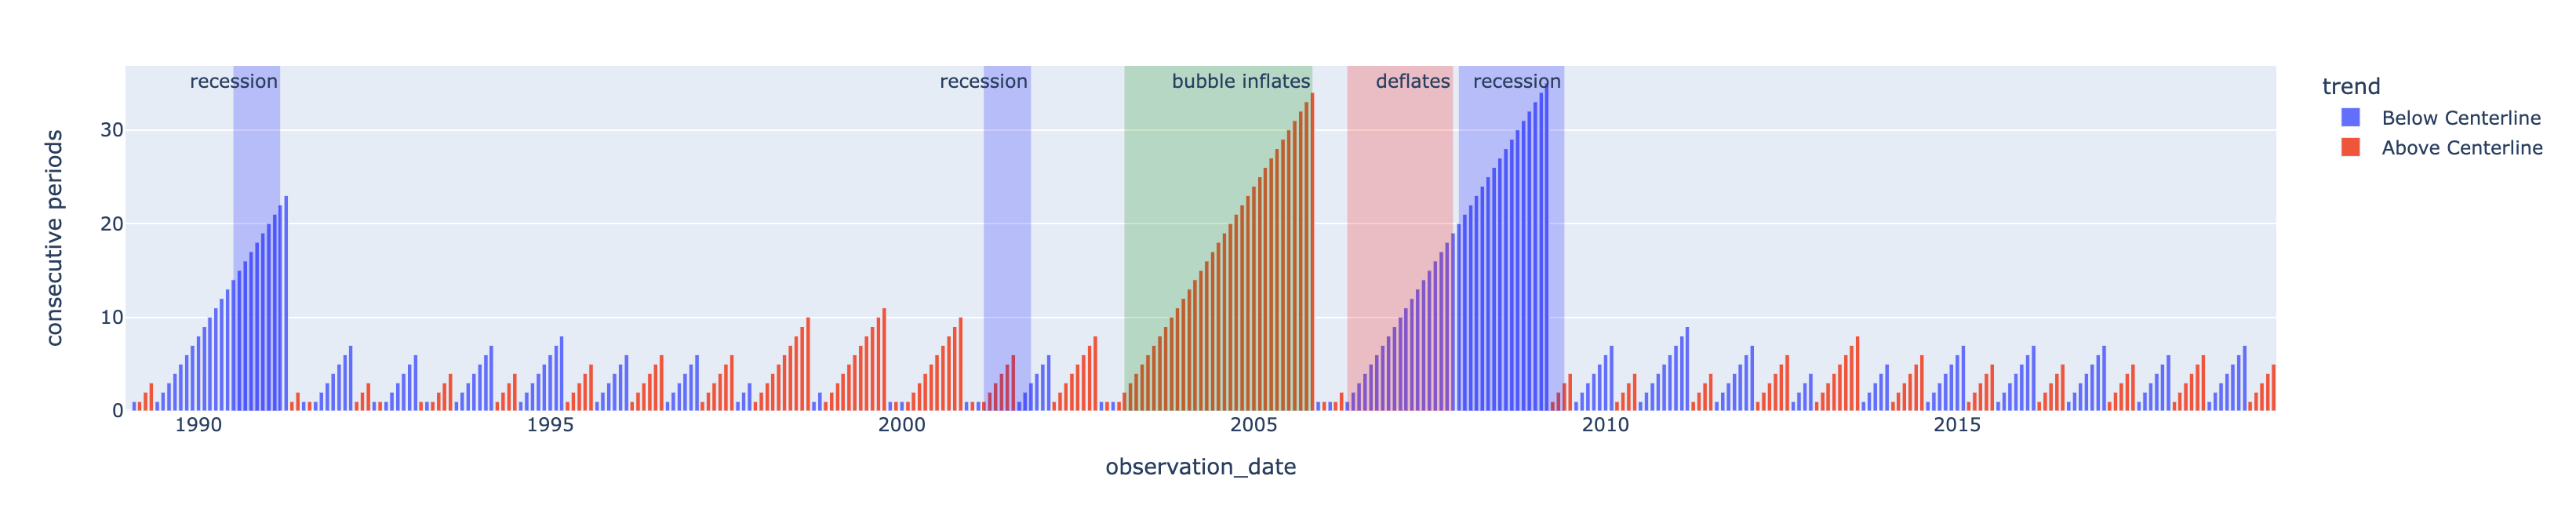

In [16]:
trend_scatter = px.bar(trend_df, x='observation_date', y='combined_trend', color='trend')
trend_scatter.add_vrect(x0='2007-12-01', x1='2009-06-01', line_width=0, fillcolor="blue", opacity=0.2, annotation_text="recession")
trend_scatter.add_vrect(x0='2001-03-01', x1='2001-11-01', line_width=0, fillcolor="blue", opacity=0.2, annotation_text="recession")
trend_scatter.add_vrect(x0='1990-07-01', x1='1991-03-01', line_width=0, fillcolor="blue", opacity=0.2, annotation_text="recession")
trend_scatter.add_vrect(x0='2003-03-01', x1='2005-11-01', line_width=0, fillcolor="green", opacity=0.2, annotation_text="bubble inflates")
trend_scatter.add_vrect(x0='2006-05-01', x1='2007-11-01', line_width=0, fillcolor="red", opacity=0.2, annotation_text="deflates")
trend_scatter.update_yaxes(title_text="consecutive periods")
trend_scatter
Image(filename='./images/trend.png', width=1600)

The plot above tells the whole story. The "serrations" indicate (using z-scores) how the percent change between the housing and rent indices are "trending" over time. 

As we have explained previously, scores above the centerline (red) indicate that the housing prices are rising at a faster rate than rents, as reflected in their corresponding indices. In other words, consecutive periods above the centerline indicate the "bubble" is inflating, whereas consecutive periods below represent the bubble is starting to deflate and we are heading into a recession.

---